In [36]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [11]:
import os
import pandas as pd

# Paths to directories
train_def_path = '/content/casting_data/casting_data/train/def_front'
train_ok_path = '/content/casting_data/casting_data/train/ok_front'
test_def_path = '/content/casting_data/casting_data/test/def_front'
test_ok_path = '/content/casting_data/casting_data/test/ok_front'

# Function to create dataset with filenames and labels
def create_dataset_with_labels(directory, label):
    dataset = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        dataset.append({"filename": file_path, "label": label})
    return dataset

# Creating datasets for each category
train_def_dataset = create_dataset_with_labels(train_def_path, label=1)
train_ok_dataset = create_dataset_with_labels(train_ok_path, label=0)
test_def_dataset = create_dataset_with_labels(test_def_path, label=1)
test_ok_dataset = create_dataset_with_labels(test_ok_path, label=0)

# Combine all datasets
combined_dataset = train_def_dataset + train_ok_dataset + test_def_dataset + test_ok_dataset

# Convert to DataFrame
df = pd.DataFrame(combined_dataset)

In [24]:
df.head()



,filename,label
0,/content/casting_data/casting_data/train/def_f...,1
1,/content/casting_data/casting_data/train/def_f...,1
2,/content/casting_data/casting_data/train/def_f...,1
3,/content/casting_data/casting_data/train/def_f...,1
4,/content/casting_data/casting_data/train/def_f...,1


In [25]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to convert image paths to image arrays
def convert_images_to_arrays(dataframe, img_size=(128, 128)):
    images = []
    labels = []
    for _, row in dataframe.iterrows():
        img_path = row["filename"]
        label = row["label"]
        try:
            img = load_img(img_path, target_size=img_size)  # Load and resize image
            img_array = img_to_array(img) / 255.0  # Convert to array and normalize
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image: {img_path}, Error: {e}")
    return np.array(images), np.array(labels)

# Convert the DataFrame into image arrays and labels
x_data, y_data = convert_images_to_arrays(df)

# Output the shapes of the resulting arrays for verification
x_data.shape, y_data.shape


((7348, 128, 128, 3), (7348,))

In [27]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Output the shapes of the resulting arrays for verification
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((5878, 128, 128, 3), (1470, 128, 128, 3), (5878,), (1470,))

In [34]:
np.unique(y_test)

array([0, 1])

In [37]:
def build_cnn(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Define model parameters
input_shape = x_train[0].shape  # Shape of one image
num_classes = len(np.unique(y_train))  # Number of unique labels

# Build and compile the model
model = build_cnn(input_shape, num_classes)

In [39]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer
    loss='sparse_categorical_crossentropy',  # Loss function for integer labels
    metrics=['accuracy']  # Metric to monitor during training
)


In [40]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Train the model
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9932 - loss: 0.0272 - val_accuracy: 0.9864 - val_loss: 0.0409
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9928 - loss: 0.0247 - val_accuracy: 0.9719 - val_loss: 0.0814
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9791 - loss: 0.0509 - val_accuracy: 0.9821 - val_loss: 0.0624
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9808 - loss: 0.0600 - val_accuracy: 0.9923 - val_loss: 0.0288
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9979 - loss: 0.0140 - val_accuracy: 0.9923 - val_loss: 0.0303
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9940 - val_loss: 0.0320
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9970 - loss: 0.0085 - val_accuracy: 0.9940 - val_loss: 0.0414
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9956 - loss: 0.0147 - val_accu

In [48]:
# Save the trained model
model.save('cnn_model.h5')  # Save as an HDF5 file
print("Model saved successfully!")


Model saved successfully!


In [43]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.9948 - loss: 0.0173
Test Loss: 0.0157, Test Accuracy: 0.9952


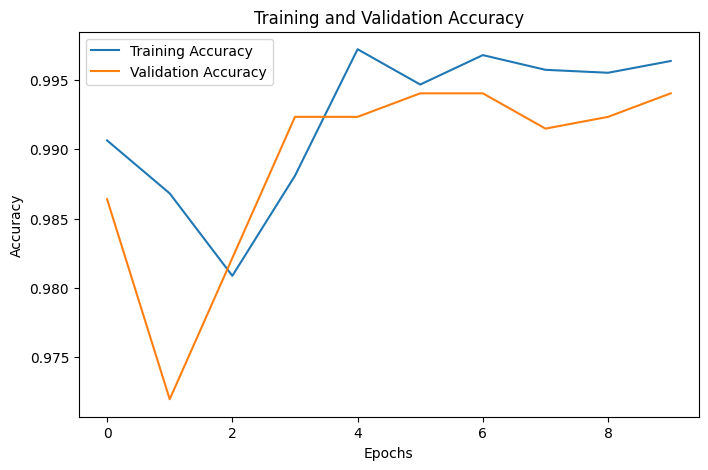

In [44]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

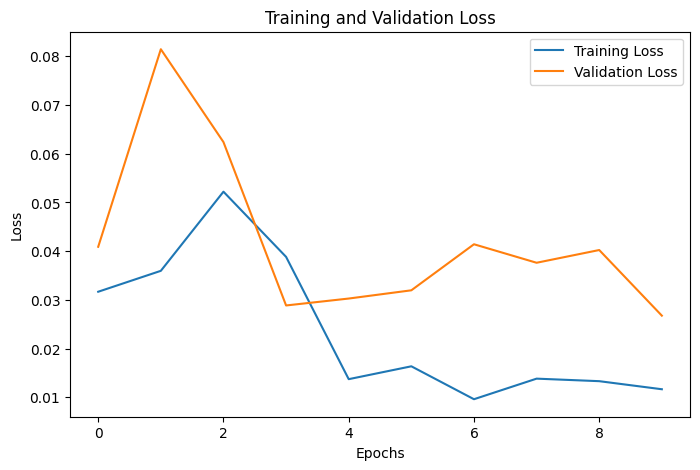

In [45]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## predictive

In [46]:
# Make predictions on the test set
predictions = model.predict(x_test)

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print some sample predictions along with actual labels
for i in range(10):  # Display 10 sample predictions
    print(f"Image {i+1}: Predicted = {predicted_classes[i]}, Actual = {y_test[i]}")

# Evaluate overall accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Prediction Accuracy: {accuracy:.4f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predicted_classes))


46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 530ms/step
Image 1: Predicted = 1, Actual = 1
Image 2: Predicted = 1, Actual = 1
Image 3: Predicted = 0, Actual = 0
Image 4: Predicted = 1, Actual = 1
Image 5: Predicted = 1, Actual = 1
Image 6: Predicted = 1, Actual = 1
Image 7: Predicted = 0, Actual = 1
Image 8: Predicted = 1, Actual = 1
Image 9: Predicted = 1, Actual = 1
Image 10: Predicted = 0, Actual = 0
Prediction Accuracy: 0.9952

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       628
           1       1.00      0.99      1.00       842

    accuracy                           1.00      1470
   macro avg       0.99      1.00      1.00      1470
weighted avg       1.00      1.00      1.00      1470


Confusion Matrix:
[[628   0]
 [  7 835]]


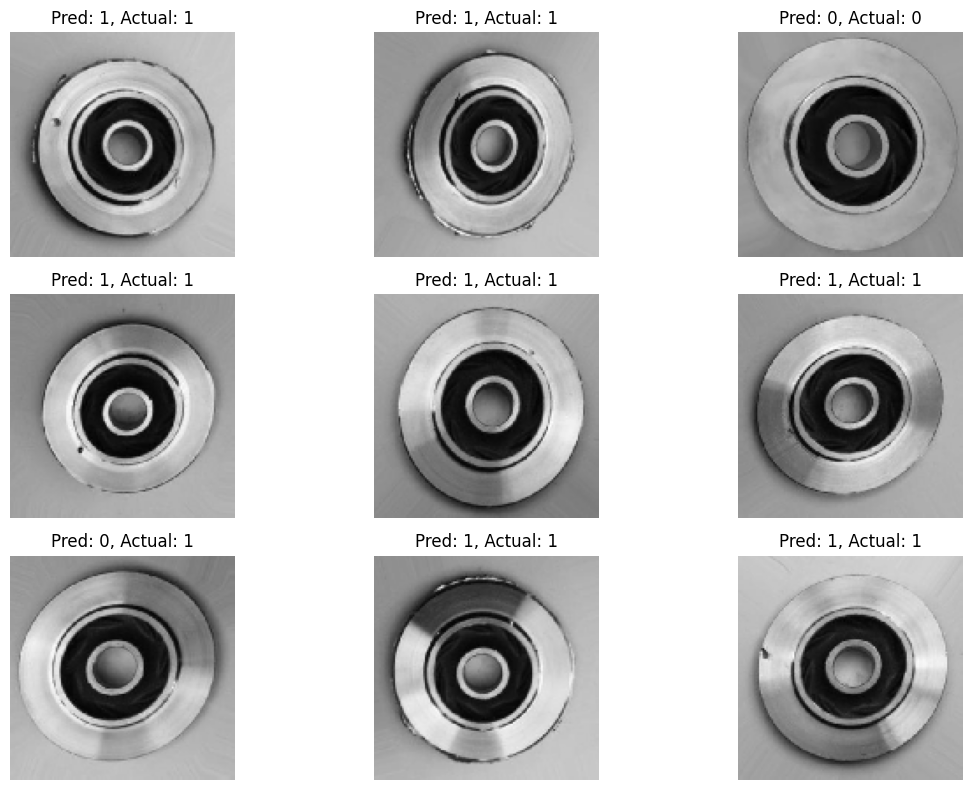

In [47]:
import matplotlib.pyplot as plt

# Visualize some test images with predictions
plt.figure(figsize=(12, 8))
for i in range(9):  # Show 9 sample images
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Pred: {predicted_classes[i]}, Actual: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [52]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model  # Import load_model
import numpy as np

# Load the saved model
saved_model = load_model('/Users/tamilselavans/Downloads/cnn_model.h5')
print("Model loaded successfully!")

# Path to the custom image
custom_image_path = '/content/casting_data/casting_data/train/def_front/cast_def_0_1001.jpeg'  # Replace with your image path

# Load and preprocess the image
img_size = (128, 128)  # Ensure this matches the training input size
custom_img = load_img(custom_image_path, target_size=img_size)  # Load image
custom_img_array = img_to_array(custom_img) / 255.0  # Convert to array and normalize
custom_img_array = np.expand_dims(custom_img_array, axis=0)  # Add batch dimension

# Make predictions
prediction = saved_model.predict(custom_img_array)
predicted_class = np.argmax(prediction)  # Get the class with the highest probability

# Display results
class_labels = {0: 'Not Defective', 1: 'Defective'}  # Adjust labels as per your training data
print(f"Predicted Class: {predicted_class}, Label: {class_labels[predicted_class]}")


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted Class: 1, Label: Defective
